In [3]:
import argparse
import mimetypes
import time
from google import genai
from google.genai import types

import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
MODEL_NAME = "gemini-2.5-flash-image-preview"

In [ ]:
## Utils Functions

def _get_mime_type(file_path: str) -> str:
    """Guesses the MIME type of a file based on its extension."""
    mime_type, _ = mimetypes.guess_type(file_path)
    print(f"The mime type of {file_path} is:", mime_type)
    if mime_type is None:
        raise ValueError(f"Could not determine MIME type for {file_path}")
    return mime_type

def _load_image_parts(image_paths: list[str]) -> list[types.Part]:
    """Loads image files and converts them into GenAI Part objects."""
    parts = []
    for image_path in image_paths:
        with open(image_path, "rb") as f:
            image_data = f.read()
        mime_type = _get_mime_type(image_path)
        parts.append(
            types.Part(inline_data=types.Blob(data=image_data, mime_type=mime_type))
        )
    return parts

def _save_binary_file(file_name: str, data: bytes):
    """Saves binary data to a specified file."""
    with open(file_name, "wb") as f:
        f.write(data)
    print(f"File saved to: {file_name}")

def _process_api_response(response, output_dir: str):
    """Processes the response from the GenAI API, saving images and printing text."""
    file_index = 0
    print("Processing API response (stream False)...")
    print("len candidates:", len(response.candidates))
    for part in response.candidates[0].content.parts:
        if part.inline_data and part.inline_data.data:
            timestamp = int(time.time())
            file_extension = mimetypes.guess_extension(part.inline_data.mime_type)
            file_name = os.path.join(
                output_dir,
                f"remixed_image_{timestamp}_{file_index}{file_extension}",
            )
            _save_binary_file(file_name, part.inline_data.data)
            file_index += 1
        elif part.text:
            print(part.text)
            
def _process_api_stream_response(stream, output_dir: str):
    """Processes the streaming response from the GenAI API, saving images and printing text."""
    file_index = 0
    for chunk in stream:
        if (
            chunk.candidates is None
            or chunk.candidates[0].content is None
            or chunk.candidates[0].content.parts is None
        ):
            continue

        for part in chunk.candidates[0].content.parts:
            if part.inline_data and part.inline_data.data:
                timestamp = int(time.time())
                file_extension = mimetypes.guess_extension(part.inline_data.mime_type)
                file_name = os.path.join(
                    output_dir,
                    f"remixed_image_{timestamp}_{file_index}{file_extension}",
                )
                _save_binary_file(file_name, part.inline_data.data)
                file_index += 1
            elif part.text:
                print(part.text)



## ---------

def remix_images(
    image_paths: list[str],
    prompt: str,
    output_dir: str,
    stream: bool = True,
):
    """
    Remixes two images using the Google Generative AI model.

    Args:
        image_paths: A list of two paths to input images.
        prompt: The prompt for remixing the images.
        output_dir: Directory to save the remixed images.
    """
    api_key = os.environ.get("GEMINI_API_KEY")
    if not api_key:
        raise ValueError("GEMINI_API_KEY environment variable not set.")

    client = genai.Client(api_key=api_key)

    contents = _load_image_parts(image_paths)
    contents.append(genai.types.Part.from_text(text=prompt))

    generate_content_config = types.GenerateContentConfig(
        response_modalities=["IMAGE", "TEXT"],
    )

    print(f"Remixing with {len(image_paths)} images and prompt: {prompt}")


    if stream:
        print("Using streaming response...")
        stream = client.models.generate_content_stream(
            model=MODEL_NAME,
            contents=contents,
            config=generate_content_config,
        )

        _process_api_stream_response(stream, output_dir)
    else:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=contents,
            config=generate_content_config,
        )
        _process_api_response(response, output_dir)
        











# if __name__ == "__main__":
#     main()

In [31]:
remix_images(
    image_paths=["./images/valentim.jpg", "./images/oculos_2.png"],
    prompt="Misture as duas imagens e coloque um fundo colorido. Mantenha as dimensões da imagem original.",
    output_dir="./output",
    stream=False
)

The mime type of ./images/valentim.jpg is: image/jpeg
The mime type of ./images/oculos_2.png is: image/png
Remixing with 2 images and prompt: Misture as duas imagens e coloque um fundo colorido. Mantenha as dimensões da imagem original.
Processing API response (stream False)...
len candidates: 1
File saved to: ./output\remixed_image_1756856362_0.png


In [ ]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO

from IPython.display import display

client = genai.Client()

def _load_image_parts(image_paths: list[str]) -> list[Image]:
    """Loads image files and converts them into GenAI Part objects."""
    parts = []
    for image_path in image_paths:
        parts.append(Image.open(image_path))
    return parts

def get_response_and_save_image(response, output_dir: str):

    image_parts = [
        part.inline_data.data
        for part in response.candidates[0].content.parts
        if part.inline_data
    ]

    if image_parts:
        image = Image.open(BytesIO(image_parts[0]))
        image.save(os.path.join(output_dir, 'remixed_image.png'))
    
    return BytesIO(image_parts[0]), os.path.join(output_dir, 'remixed_image.png')

def remix_images(image_paths: list[str], 
                 prompt: str,
                 output_dir: str) -> Image:
    """Remixes the given images based on the text prompt."""
    contents = _load_image_parts(image_paths)
    contents.append(prompt)

    generate_content_config = types.GenerateContentConfig(
        response_modalities=["IMAGE", "TEXT"],
    )

    response = client.models.generate_content(
        model="gemini-2.5-flash-image-preview",
        contents=contents,
        config=generate_content_config
    )


    return get_response_and_save_image(response, output_dir)

In [13]:
img, path = remix_images(
    image_paths=["./images/valentim.jpg", 
                 "./images/sapato.png"],
    prompt="Coloque o sapato no meu pé. Crie o resto da imagem caso precise",
    output_dir='./output',
)

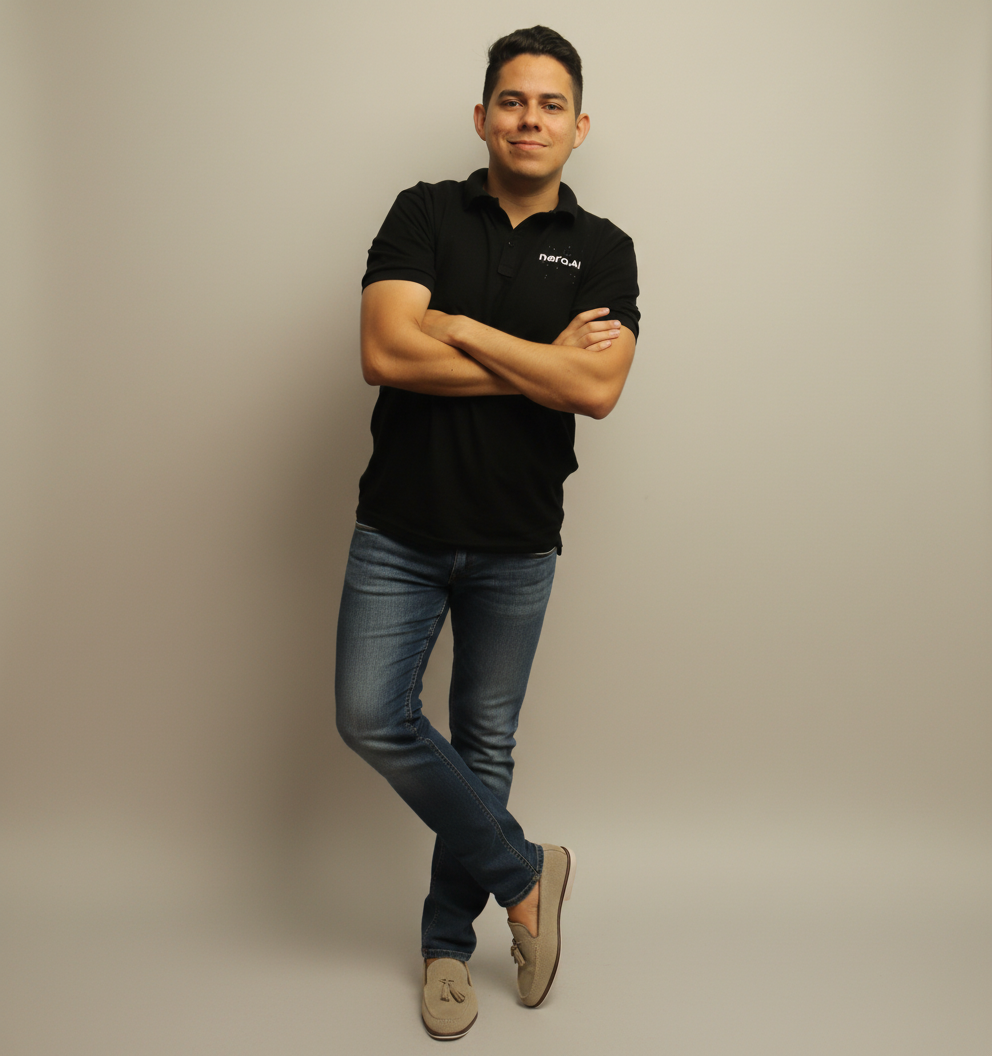

In [14]:
display(img)

In [ ]:


image_parts = [
    part.inline_data.data
    for part in response.candidates[0].content.parts
    if part.inline_data
]

if image_parts:
    image = Image.open(BytesIO(image_parts[0]))
    image.save('./output/new_method.png')


In [37]:
contents

In [ ]:
# To run this code you need to install the following dependencies:
# pip install google-genai

import base64
import mimetypes
import os
from google import genai
from google.genai import types


def save_binary_file(file_name, data):
    f = open(file_name, "wb")
    f.write(data)
    f.close()
    print(f"File saved to to: {file_name}")


def generate():
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.5-flash-image-preview"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""INSERT_INPUT_HERE"""),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        response_modalities=[
            "IMAGE",
            "TEXT",
        ],
    )

    file_index = 0
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        if (
            chunk.candidates is None
            or chunk.candidates[0].content is None
            or chunk.candidates[0].content.parts is None
        ):
            continue
        if chunk.candidates[0].content.parts[0].inline_data and chunk.candidates[0].content.parts[0].inline_data.data:
            file_name = f"ENTER_FILE_NAME_{file_index}"
            file_index += 1
            inline_data = chunk.candidates[0].content.parts[0].inline_data
            data_buffer = inline_data.data
            file_extension = mimetypes.guess_extension(inline_data.mime_type)
            save_binary_file(f"{file_name}{file_extension}", data_buffer)
        else:
            print(chunk.text)

if __name__ == "__main__":
    generate()